In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from math import ceil

In [2]:
tf.__version__

'2.3.0'

In [3]:
test = pd.read_csv('Dataset.csv')
label = test['label']
unique = np.unique(label)

In [4]:
unique

array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
       'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma',
       'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron',
       'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen',
       'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan',
       'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow',
       'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra',
       'Robert Downey Jr', 'Roger Federer', 'Tom Cruise',
       'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron'], dtype=object)

In [5]:
data = np.load('embeddings.npz', allow_pickle = True)
X, y = data['arr_0'], data['arr_1']

In [6]:
encode = LabelEncoder().fit(y)
y_encode = encode.transform(y)

In [7]:
X_normalize = Normalizer().transform(X)

In [8]:
model_facenet = tf.keras.models.load_model('model/facenet_keras.h5')

In [9]:
model_SVC = SVC(kernel = 'linear', probability = True)

In [10]:
model_SVC.fit(X_normalize, y_encode)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
detector = MTCNN()

In [13]:
def get_embedding(face, model = model_facenet):
    face = face.astype(np.float32)
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    face = np.expand_dims(face, axis=0)
    face = model.predict(face)
    return face[0]

In [14]:
def draw_rectangle(frame, x1, y1, x2, y2, pred, pred_proba):
    proba = np.max(pred_proba)
    size1 = (x2-x1) * 3 / 500
    size2 = ceil((x2-x1) * 3 / 700)
    if proba > 0.50:
        text = str(unique[pred][0]) + " " + str(int(proba*100)) + '%'
        color = (0,255,0)
    else:
        text = 'INTRUDER'
        color = (255,0,0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(frame, pt1 = (x1,y1), pt2 = (x2,y2), color = color, thickness = size2)
    cv2.putText(frame, text, org = (x1, y1), fontFace=font, fontScale=size1 , color=color, thickness=size2)
    return frame

In [16]:
IMG_SIZE = 160
def detect_face(frame, size = (IMG_SIZE, IMG_SIZE), model = model_SVC):
    result = detector.detect_faces(frame)
    for temp in result:
#         if temp['confidence'] > 0.8:
            x1, y1, width, height = temp['box']
            x2, y2 = x1+width, y1+height
            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, size)
            emdface = get_embedding(face)
            normface = Normalizer().transform([emdface])
            pred = model.predict(normface)
            pred_proba = model.predict_proba(normface)
            frame = draw_rectangle(frame, x1, y1, x2, y2, pred, pred_proba)
#         else:
#             print(temp)
    return frame

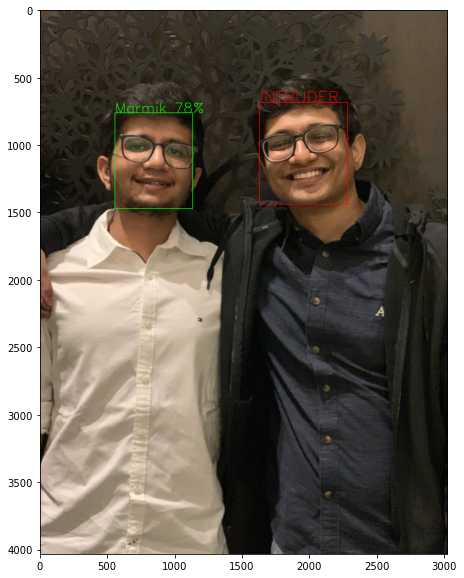

In [17]:
plt.figure(figsize=(10,10))
a = plt.imread('IMG_7408.jpg')
plt.imshow(detect_face(a))

In [18]:
vid = cv2.VideoCapture(0)

while True:
    
    try:
        res, frame = vid.read()
    except Exception as e:
        print(e)
        print('Error during video read')
        
    try:
        if res == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = detect_face(frame)
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            cv2.imshow('test', frame)
    except Exception as e:
        print(e)
        print('Error during frame processing')
        
    if cv2.waitKey(1) == 27:
        break

vid.release()
cv2.destroyAllWindows()

In [25]:
vid.release()